### Resources:
https://medium.com/@siavash_37715/how-to-predict-bitcoin-and-ethereum-price-with-rnn-lstm-in-keras-a6d8ee8a5109

http://ceur-ws.org/Vol-2280/paper-06.pdf


# PROCESSING THE DATASET

In [206]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# DataFrame
import pandas as pd
import gc
import datetime

# Matplot
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Set up directory
dir = '/content/gdrive/My Drive/Internship document/Softbank AI Lab/2nd semester/'

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from math import sqrt

#Pytorch
import torch
from torchvision import datasets, models, transforms

#Keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD

#XGBoost
from xgboost import XGBClassifier

## Parameter tuning

In [0]:
#Set up parameter to create the dataset
time_series_col = ['BTC_log_return', 'ETH_log_return', 'LTC_log_return',]
ext_regressors = [ 'EPU_UK_log', 'EPU_UK_log_return', 'EPU_US_log', 'EPU_US_log_return', 'EPU_AVG_log', 'EPU_AVG_log_return']
window_len_BTC = 7
window_len_ext = 5    
window_len_BTC_future = 7

In [0]:
#LSTM model parameter
neurons = 50                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer="adam"              
dropout = 0.3                 
batch_size = 40               
epochs = 400                   

## Supporting function

In [0]:
def EPU_Clean (data, EPU_date_cols):
    data['Date'] = pd.to_datetime(data[EPU_date_cols])
    data = data.drop(EPU_date_cols, axis=1)
    cols = data.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data = data[cols]
    data = data.sort_values('Date')
    data = data[(data.Date>Starting_date)].reset_index().drop(['index'], axis=1)
    return data

def Crypto_Clean (data, Crypto_drop_cols):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.drop(Crypto_drop_cols, axis = 1)
    return data

def Commodity_Clean (data):
    data['Date']=pd.to_datetime(data.Date)
    return data

def Sort (data, Starting_date):
    data = data.sort_values('Date')
    data = data[(data.Date>Starting_date)].reset_index().drop(['index'], axis=1)
    return data

def Merge (BTC, ETH, LTC, EPU_UK, EPU_US, Gold, Oil, with_weekend = True): 
    data = pd.merge (BTC, ETH, on = 'Date', how = 'left')
    data = pd.merge (data, LTC, on = 'Date', how = 'right')
    data = pd.merge (data, EPU_UK, on = 'Date', how = 'right')
    data = pd.merge (data, EPU_US, on = 'Date', how = 'right')
    data.columns = ['Date','BTC','Volume BTC','ETH','Volume ETH', 'LTC', 'Volume LTC','EPU_UK', 'EPU_US']
    if with_weekend == False:
        data = pd.merge (data, Gold, on = 'Date', how = 'right')
        data = pd.merge (data, Oil, on = 'Date', how = 'right')
        data.columns = ['Date','BTC','Volume BTC','ETH','Volume ETH', 'LTC', 'Volume LTC','EPU_UK', 'EPU_US','Gold', 'Oil']
    data.dropna(axis=0, how='any',inplace=True) #remove any observations that has null values in at least one column
    return data

def log_return_value (series):
    series_1 = np.log(series)
    series_2 = series_1 - series_1.shift(1)
    series_3 = series_2.shift(1)
    return series_1, series_2, series_3

def EPU_AVG (data): 
    data['EPU_US_return'] = (data['EPU_US']-data['EPU_US'].shift(1)) 
    data['EPU_UK_return'] = (data['EPU_UK']-data['EPU_UK'].shift(1)) 
    data['EPU_AVG_log'] = ((data['EPU_UK_log']+data['EPU_US_log'])/2).round(2) #Generate a new column
    data['EPU_AVG_log_shift'] = data['EPU_AVG_log'].shift(1)
    data['EPU_AVG_log_return'] = ((data['EPU_UK_log_return']+data['EPU_US_log_return'])/2).round(2) #Generate a new column
    data['EPU_AVG_log_return_shift'] = data['EPU_AVG_log_return'].shift(1)
    return data

def log_generated (data):
    log_cols = ['BTC','ETH','LTC','EPU_UK','EPU_US','Gold','Oil']
    for i in log_cols:
        if i in data.columns:
            data[f'{i}_log'], data[f'{i}_log_return'], data[f'{i}_log_return_shift'] = log_return_value (data[i])
    EPU_AVG(data)
    return data

def Split_Train_Test (data, train_len = 0.8):
    N = len (data)
    Train = data.iloc[0:int(N*train_len),].reset_index().drop(['index'], axis=1)
    Test = data.iloc[int(N*train_len):,].reset_index().drop(['index'], axis=1)
    return Train, Test

def create_new_dataset(data, time_series_col = time_series_col, ext_regressors=ext_regressors, window_len = window_len_BTC, window_len_ext = window_len_ext, dropnan=True, window_predict = window_len_BTC_future):
  df2 = data.copy()
  predict_col = []
  x_col = ext_regressors + ['BTC_log_return'].copy()
  for i in range (window_len):
    df2[('BTC_log_return t-%d' % (i+1))] = df2['BTC_log_return'].shift((i+1))
    x_col.append('BTC_log_return t-%d' % (i+1))
  for j in (ext_regressors):
    for k in range (window_len_ext):
      df2[('%s t - %d' % (j, k+1))] = df2[j].shift((k+1))
      x_col.append('%s t - %d' % (j, k+1))
  for g in range (window_predict): 
    df2[('BTC_log_return t+%d' % (g+1))] = df2['BTC_log_return'].shift(-(g+1))
    predict_col.append('BTC_log_return t+%d' % (g+1))
  if dropnan:
    df2.dropna(inplace=True)
  X_value = df2[x_col].copy()
  Y_value = df2[predict_col].copy()
  return X_value, Y_value

## Reading dataset

In [215]:
%%time
BTC = pd.read_csv(dir + 'BTC_.csv')
ETH = pd.read_csv(dir + 'ETH_.csv')
LTC = pd.read_csv(dir + 'LTC_.csv')
EPU_UK = pd.read_csv(dir + 'UK_Daily.csv')
EPU_US = pd.read_csv(dir + 'US_Daily.csv')
Gold = pd.read_csv(dir + 'Gold_.csv')
Oil = pd.read_csv(dir + 'Oil_.csv')

Starting_date = '2014-12-01'
EPU_date_cols = ['year', 'month', 'day']
Crypto_drop_cols = ['Open','High','Low','Volume USD', 'Symbol']    

Gold = Sort(Commodity_Clean(Gold), Starting_date)
Oil = Sort(Commodity_Clean(Oil), Starting_date)
EPU_UK = Sort(EPU_Clean(EPU_UK, EPU_date_cols), Starting_date)
EPU_US = Sort(EPU_Clean(EPU_US, EPU_date_cols), Starting_date)
BTC = Sort(Crypto_Clean(BTC, Crypto_drop_cols), Starting_date)
ETH = Sort(Crypto_Clean(ETH, Crypto_drop_cols), Starting_date)
LTC = Sort(Crypto_Clean(LTC, Crypto_drop_cols), Starting_date)

CPU times: user 431 ms, sys: 5.81 ms, total: 437 ms
Wall time: 446 ms


## Create a new dataset

In [216]:
%%time

# #Weekend_No_weekend
Weekend = Merge (BTC, ETH, LTC, EPU_UK, EPU_US, Gold, Oil, with_weekend = True)
Weekend = log_generated (Weekend)
No_weekend = Merge (BTC, ETH, LTC, EPU_UK, EPU_US, Gold, Oil, with_weekend = False)
No_weekend = log_generated (No_weekend)

# #Choosing columns of interest No Weekend
# X_value, Y_value = create_new_dataset (No_weekend)
# Train_X, Test_X = Split_Train_Test (X_value)
# Train_Y, Test_Y = Split_Train_Test (Y_value)

# Choosing columns of interest With Weekend
X_value, Y_value = create_new_dataset (Weekend)
Train_X, Test_X = Split_Train_Test (X_value)
Train_Y, Test_Y = Split_Train_Test (Y_value)

CPU times: user 127 ms, sys: 484 µs, total: 127 ms
Wall time: 129 ms


## XGBOOST (Not runnable because of small values)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


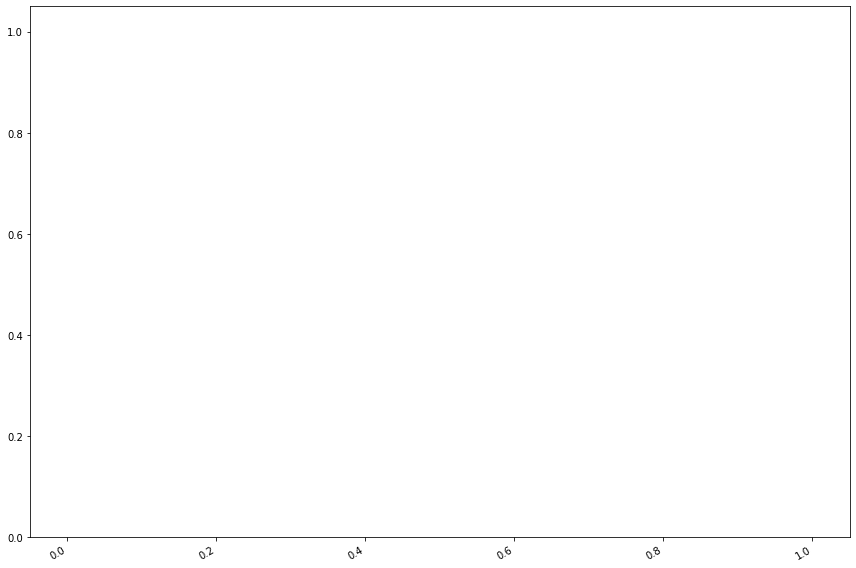

In [0]:
model = XGBClassifier()
model.fit(Train_X.values, Train_Y)
# feature importance
print(model.feature_importances_)
# plot
plt.figure (figsize = (12,8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.gcf().autofmt_xdate()
plt.tight_layout()

# TRAINING THE MACHINE LEARNING MODEL

## LSTM (accuracy 54%)

### Build the model

In [0]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

### Run the model


In [223]:
# #Change the shape of the dataset
X_train_LSTM = Train_X.values.reshape(Train_X.shape[0], 1, Train_X.shape[1])
X_test_LSTM = Test_X.values.reshape(Test_X.shape[0], 1, Test_X.shape[1])

# # clean up the memory
gc.collect()

# # Initialise a new model
# btc_model = build_model(X_train_LSTM, output_size=Test_Y.shape[1], neurons=neurons)

#Load model
btc_model = torch.load(F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/2nd semester/model_2.h5")

# train model on data
btc_history = btc_model.fit(X_train_LSTM, Train_Y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_LSTM, Test_Y), shuffle=False)

# save the model according to the conditions  
model_save_name = "model_2.h5"
path = F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/2nd semester/{model_save_name}" 
torch.save(btc_model, path)

Train on 1004 samples, validate on 251 samples
Epoch 1/400
1004/1004 [==============================] - 3s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0271 - val_loss: 0.0015 - val_mean_absolute_error: 0.0279
Epoch 2/400
1004/1004 [==============================] - 0s 366us/step - loss: 0.0015 - mean_absolute_error: 0.0273 - val_loss: 0.0015 - val_mean_absolute_error: 0.0276
Epoch 3/400
1004/1004 [==============================] - 0s 406us/step - loss: 0.0015 - mean_absolute_error: 0.0271 - val_loss: 0.0015 - val_mean_absolute_error: 0.0278
Epoch 4/400
1004/1004 [==============================] - 0s 353us/step - loss: 0.0015 - mean_absolute_error: 0.0272 - val_loss: 0.0015 - val_mean_absolute_error: 0.0277
Epoch 5/400
1004/1004 [==============================] - 0s 356us/step - loss: 0.0015 - mean_absolute_error: 0.0271 - val_loss: 0.0015 - val_mean_absolute_error: 0.0278
Epoch 6/400
1004/1004 [==============================] - 0s 366us/step - loss: 0.0015 - mean_absolute_error: 0

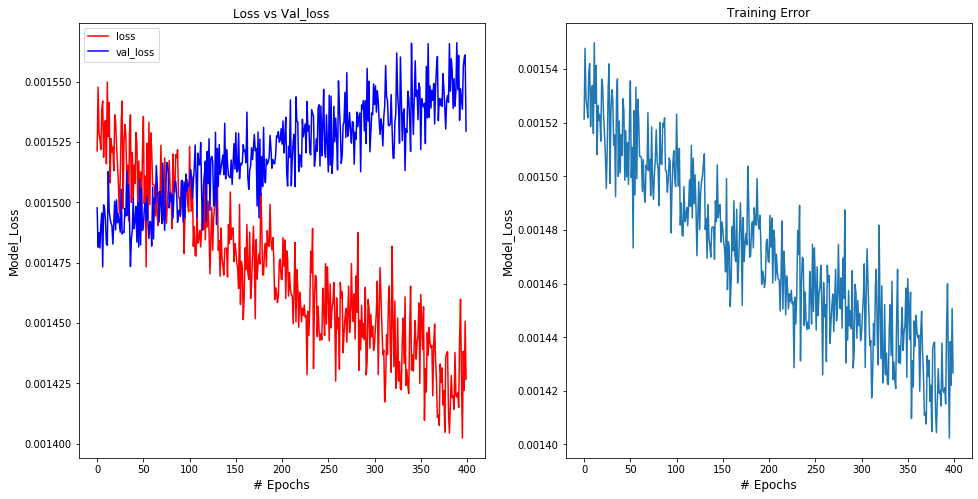

In [224]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].plot(btc_history.epoch, btc_history.history['loss'], label = 'loss', color = 'r')
axs[0].plot(btc_history.epoch, btc_history.history['val_loss'], label = 'val_loss', color = 'b')
axs[0].set_title('Loss vs Val_loss')
axs[0].set_ylabel('Model_Loss', fontsize=12)
axs[0].set_xlabel('# Epochs',fontsize=12)
axs[0].legend()


axs[1].plot(btc_history.epoch, btc_history.history['loss'])
axs[1].set_title('Training Error')
axs[1].set_ylabel('Model_Loss', fontsize=12)
axs[1].set_xlabel('# Epochs',fontsize=12)

plt.show()

Test RMSE: 0.039
Classification report of tomorrow is:
              precision    recall  f1-score   support

       False       0.49      0.49      0.49       129
        True       0.46      0.47      0.47       122

    accuracy                           0.48       251
   macro avg       0.48      0.48      0.48       251
weighted avg       0.48      0.48      0.48       251



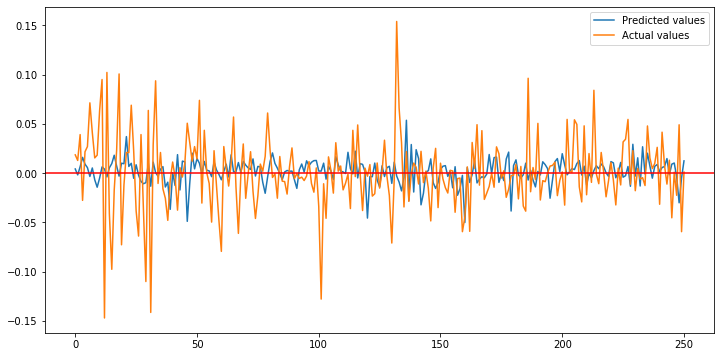

In [233]:
#Prediction
# make a prediction
yhat = btc_model.predict(X_test_LSTM)

# calculate RMSE
rmse = sqrt(mean_squared_error(yhat, Test_Y))
print('Test RMSE: %.3f' % rmse)

#Classification report of tomorrow
print("Classification report of tomorrow is:")
print(classification_report(Test_Y['BTC_log_return t+1']>0, yhat[:,0]>0))

# Plot the result
plt.figure (figsize = (12,6))
plt.plot (yhat[:,1], label = 'Predicted values')
plt.plot (Test_Y['BTC_log_return t+1'], label = "Actual values")
plt.axhline (y = 0, color = 'r')
plt.legend()

Classification report of the whole week is:
              precision    recall  f1-score   support

       False       0.61      0.45      0.52       137
        True       0.50      0.65      0.56       114

    accuracy                           0.54       251
   macro avg       0.55      0.55      0.54       251
weighted avg       0.56      0.54      0.54       251



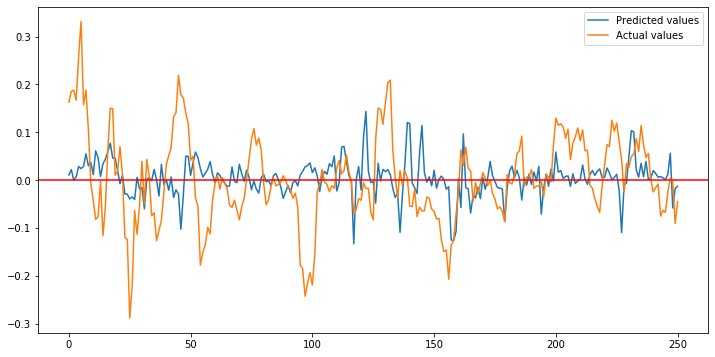

In [226]:
#Classification report
print("Classification report of the whole week is:")
print(classification_report(Test_Y.sum(1)>0, yhat.sum(1)>0))

# Plot the result
plt.figure (figsize = (12,6))
plt.plot (yhat.sum(1), label = 'Predicted values')
plt.plot (Test_Y.sum(1), label = "Actual values")
plt.axhline (y = 0, color = 'r')
plt.legend()

## Feedforward model (accuracy 51%)

### Build the model

In [0]:
ff = Sequential()
ff.add(Dense(669, input_dim=Train_X.shape[1], init="uniform",activation="relu"))
ff.add(Dropout(dropout))
ff.add(Dense(450,init ='uniform',activation = 'relu'))
ff.add(Dropout(dropout))
ff.add(Dense(300, activation="relu", kernel_initializer="uniform"))
ff.add(Dropout(dropout))
ff.add(Dense(7))
ff.add(Activation("softmax"))

sgd = SGD(lr=0.01)
ff.compile(loss="binary_crossentropy", optimizer=sgd,metrics=["accuracy"])
ff_model = ff.fit(Train_X, Train_Y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(Test_X, Test_Y), shuffle=False)

# save the model according to the conditions  
ff_model_save_name = "model_ff.h5"
path = F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/2nd semester/{ff_model_save_name}" 
torch.save(ff_model, path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(669, input_dim=56, activation="relu", kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(450, activation="relu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.


Train on 696 samples, validate on 174 samples
Epoch 1/1000
696/696 [==============================] - 1s 2ms/step - loss: 0.1613 - acc: 0.0000e+00 - val_loss: 0.1554 - val_acc: 0.0000e+00
Epoch 2/1000
696/696 [==============================] - 0s 93us/step - loss: 0.1615 - acc: 0.0000e+00 - val_loss: 0.1554 - val_acc: 0.0000e+00
Epoch 3/1000
696/696 [==============================] - 0s 100us/step - loss: 0.1614 - acc: 0.0000e+00 - val_loss: 0.1554 - val_acc: 0.0000e+00
Epoch 4/1000
696/696 [==============================] - 0s 99us/step - loss: 0.1614 - acc: 0.0000e+00 - val_loss: 0.1554 - val_acc: 0.0000e+00
Epoch 5/1000
696/696 [==============================] - 0s 103us/step - loss: 0.1614 - acc: 0.0000e+00 - val_loss: 0.1553 - val_acc: 0.0000e+00
Epoch 6/1000
696/696 [==============================] - 0s 122us/step - loss: 0.1613 - acc: 0.0000e+00 - val_loss: 0.1553 - val_acc: 0.0000e+00
Epoch 7/1000
696/696 [==============================] - 0s 112us/step - loss: 0.1613 - acc: 0.

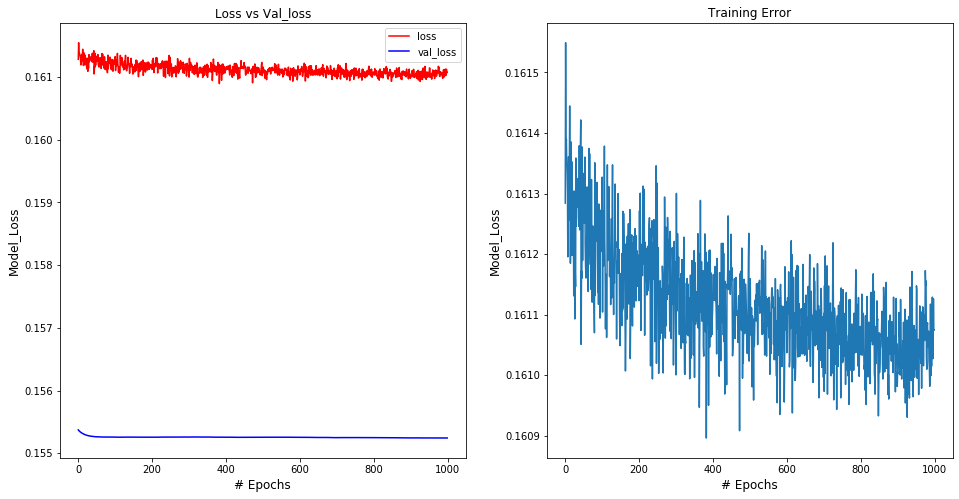

In [0]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].plot(ff_model.epoch, ff_model.history['loss'], label = 'loss', color = 'r')
axs[0].plot(ff_model.epoch, ff_model.history['val_loss'], label = 'val_loss', color = 'b')
axs[0].set_title('Loss vs Val_loss')
axs[0].set_ylabel('Model_Loss', fontsize=12)
axs[0].set_xlabel('# Epochs',fontsize=12)
axs[0].legend()


axs[1].plot(ff_model.epoch, ff_model.history['loss'])
axs[1].set_title('Training Error')
axs[1].set_ylabel('Model_Loss', fontsize=12)
axs[1].set_xlabel('# Epochs',fontsize=12)

plt.show()

In [0]:
#Prediction
# make a prediction
yhat = ff.predict(Test_X)
# invert scaling for forecast
# calculate RMSE
rmse = sqrt(mean_squared_error(yhat, Test_Y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.149


In [0]:
print(classification_report(Test_Y.sum(1)>0, yhat.sum(1)>0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        85
        True       0.51      1.00      0.68        89

    accuracy                           0.51       174
   macro avg       0.26      0.50      0.34       174
weighted avg       0.26      0.51      0.35       174



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


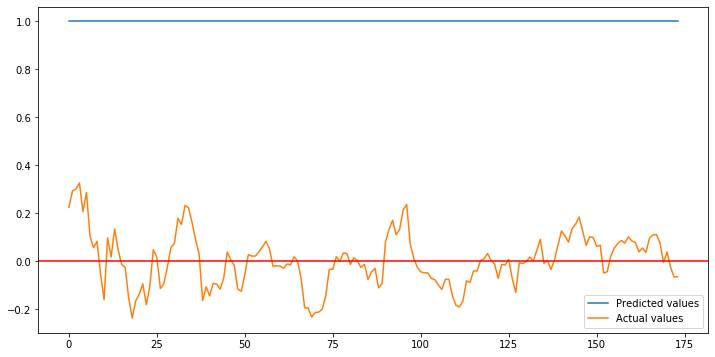

In [0]:
# Plot the result
plt.figure (figsize = (12,6))
plt.plot (yhat.sum(1), label = 'Predicted values')
plt.plot (Test_Y.sum(1), label = "Actual values")
plt.axhline (y = 0, color = 'r')
plt.legend()
plt.show()

## RANDOM FOREST (accuracy 50%)



In [228]:
from sklearn.ensemble import RandomForestRegressor

#Build the model
model = RandomForestRegressor(n_estimators=500, bootstrap = True, max_features = 'auto', max_depth=1000)
# Fit on training data
model.fit(Train_X, Train_Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1000, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Test RMSE: 0.039
Classification report of tomorrow is
              precision    recall  f1-score   support

       False       0.53      0.28      0.37       129
        True       0.49      0.74      0.59       122

    accuracy                           0.50       251
   macro avg       0.51      0.51      0.48       251
weighted avg       0.51      0.50      0.47       251



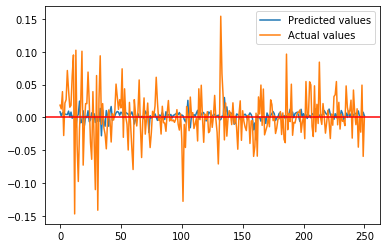

In [234]:
# Actual class predictions
y_pred = model.predict(Test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(y_pred, Test_Y))
print('Test RMSE: %.3f' % rmse)

#Classification report of tomorrow
print ("Classification report of tomorrow is")
print(classification_report(Test_Y['BTC_log_return t+1']>0, y_pred[:,0]>0))

# Plot the result
plt.plot (y_pred[:,0], label = 'Predicted values')
plt.plot (Test_Y['BTC_log_return t+1'], label = "Actual values")
plt.axhline (y = 0, color = 'r')
plt.legend()
plt.show()


Classification report of the whole week is
              precision    recall  f1-score   support

       False       0.66      0.15      0.25       137
        True       0.47      0.90      0.62       114

    accuracy                           0.49       251
   macro avg       0.56      0.53      0.43       251
weighted avg       0.57      0.49      0.42       251



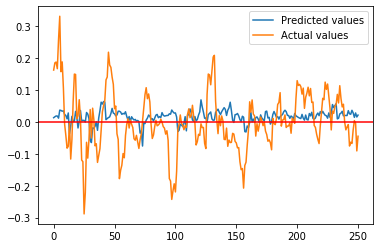

In [231]:
#Classification report of the whole week
print ("Classification report of the whole week is")
print(classification_report(Test_Y.sum(1)>0, y_pred.sum(1)>0))

# Plot the result
plt.plot (y_pred.sum(1), label = 'Predicted values')
plt.plot (Test_Y.sum(1), label = "Actual values")
plt.axhline (y = 0, color = 'r')
plt.legend()
plt.show()